# QuickBite Express - EDA & Primary Analysis (Part 1)
## Sprint 1, Task 2: Q1, Q2, Q3, Q8

**Questions Covered:**
- **Q1:** Monthly Orders — Pre-crisis vs Crisis decline severity
- **Q2:** Top 5 cities with highest % order decline
- **Q3:** Top 10 high-volume restaurants with largest % decline
- **Q8:** Revenue Impact — Estimate revenue loss

**Input:** Cleaned datasets from `output/02_cleaned_data/`
**Output:** Charts + insights to `output/03_eda_primary/`

---
## 0. Setup & Load Cleaned Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import os
from datetime import datetime

# ============================================================
# CONFIG
# ============================================================
CLEAN_DIR = "output/02_cleaned_data/"
OUTPUT_DIR = "output/03_eda_primary/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Design System Colors (matching dashboard theme)
NAVY = "#1A2744"
TEAL = "#0D8A8A"
ORANGE = "#E8743B"
SOFT_BLUE = "#5B9BD5"
LIGHT_BG = "#F0F7F7"
GRAY = "#888888"
RED = "#D94F4F"
GREEN = "#2ECC71"

# Matplotlib defaults
plt.rcParams.update({
    'figure.figsize': (14, 6),
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'font.family': 'sans-serif',
    'font.size': 11,
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.color': '#CCCCCC',
})

print("✅ Setup complete")

✅ Setup complete


In [2]:
# Load cleaned datasets
print("📂 Loading cleaned datasets...\n")

fact_orders = pd.read_csv(f"{CLEAN_DIR}fact_orders_clean.csv", parse_dates=['order_timestamp'])
fact_order_items = pd.read_csv(f"{CLEAN_DIR}fact_order_items_clean.csv")
fact_ratings = pd.read_csv(f"{CLEAN_DIR}fact_ratings_clean.csv")
fact_delivery = pd.read_csv(f"{CLEAN_DIR}fact_delivery_performance_clean.csv")
dim_customer = pd.read_csv(f"{CLEAN_DIR}dim_customer_clean.csv")
dim_restaurant = pd.read_csv(f"{CLEAN_DIR}dim_restaurant_clean.csv")
dim_delivery_partner = pd.read_csv(f"{CLEAN_DIR}dim_delivery_partner_clean.csv")
dim_menu_item = pd.read_csv(f"{CLEAN_DIR}dim_menu_item_clean.csv")

# Ensure phase column exists
if 'phase' not in fact_orders.columns:
    fact_orders['phase'] = fact_orders['order_timestamp'].apply(
        lambda x: 'Pre-Crisis' if x < pd.Timestamp('2025-06-01') else 'Crisis'
    )

if 'order_month' not in fact_orders.columns:
    fact_orders['order_month'] = fact_orders['order_timestamp'].dt.to_period('M').astype(str)

print("✅ All cleaned datasets loaded")
print(f"   fact_orders: {len(fact_orders):,} rows")
print(f"   Phase split: {fact_orders['phase'].value_counts().to_dict()}")

📂 Loading cleaned datasets...

✅ All cleaned datasets loaded
   fact_orders: 149,166 rows
   Phase split: {'Pre-Crisis': 113806, 'Crisis': 35360}


---
## Q1: Monthly Orders — Pre-Crisis vs Crisis Decline

> **Question:** Compare total orders across pre-crisis (Jan–May 2025) vs crisis (Jun–Sep 2025). How severe is the decline?

In [3]:
print("=" * 70)
print("Q1: MONTHLY ORDERS — PRE-CRISIS vs CRISIS")
print("=" * 70)

# Monthly order counts
monthly_orders = fact_orders.groupby('order_month').agg(
    total_orders=('order_id', 'count'),
    total_revenue=('total_amount', 'sum'),
    avg_order_value=('total_amount', 'mean'),
    cancellations=('is_cancelled', lambda x: (x == 'Y').sum()),
).reset_index()

monthly_orders['phase'] = monthly_orders['order_month'].apply(
    lambda x: 'Pre-Crisis' if x <= '2025-05' else 'Crisis'
)

# Calculate month-over-month change
monthly_orders['mom_change'] = monthly_orders['total_orders'].pct_change() * 100

print("\n📊 Monthly Breakdown:")
print(monthly_orders[['order_month', 'total_orders', 'total_revenue', 'avg_order_value', 'phase', 'mom_change']].to_string(index=False))

Q1: MONTHLY ORDERS — PRE-CRISIS vs CRISIS

📊 Monthly Breakdown:
order_month  total_orders  total_revenue  avg_order_value      phase  mom_change
    2025-01         23539     7774293.34       330.272881 Pre-Crisis         NaN
    2025-02         22667     7469953.31       329.551917 Pre-Crisis   -3.704490
    2025-03         23543     7802568.99       331.417788 Pre-Crisis    3.864649
    2025-04         21466     7126972.24       332.012123 Pre-Crisis   -8.822155
    2025-05         22591     7447176.37       329.652356 Pre-Crisis    5.240846
    2025-06          9293     2887866.91       310.757227     Crisis  -58.864149
    2025-07          8818     2724623.29       308.984270     Crisis   -5.111374
    2025-08          8555     2642856.29       308.925341     Crisis   -2.982536
    2025-09          8694     2684804.82       308.811228     Crisis    1.624781


In [4]:
# Summary statistics
pre_crisis = fact_orders[fact_orders['phase'] == 'Pre-Crisis']
crisis = fact_orders[fact_orders['phase'] == 'Crisis']

pre_total = len(pre_crisis)
crisis_total = len(crisis)
pre_monthly_avg = pre_total / 5
crisis_monthly_avg = crisis_total / 4
decline_pct = (1 - crisis_monthly_avg / pre_monthly_avg) * 100

print("\n📋 KEY METRICS:")
print(f"   Pre-Crisis Total Orders (Jan-May):  {pre_total:,}")
print(f"   Crisis Total Orders (Jun-Sep):      {crisis_total:,}")
print(f"   Pre-Crisis Monthly Average:         {pre_monthly_avg:,.0f}")
print(f"   Crisis Monthly Average:             {crisis_monthly_avg:,.0f}")
print(f"   \n   🔴 Monthly Order Decline:          {decline_pct:.1f}%")
print(f"   🔴 Sharpest Drop:                   May→Jun ({monthly_orders.iloc[5]['mom_change']:.1f}%)")


📋 KEY METRICS:
   Pre-Crisis Total Orders (Jan-May):  113,806
   Crisis Total Orders (Jun-Sep):      35,360
   Pre-Crisis Monthly Average:         22,761
   Crisis Monthly Average:             8,840
   
   🔴 Monthly Order Decline:          61.2%
   🔴 Sharpest Drop:                   May→Jun (-58.9%)


C:\Users\surendhar b\AppData\Local\Temp\ipykernel_10676\2289247063.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])


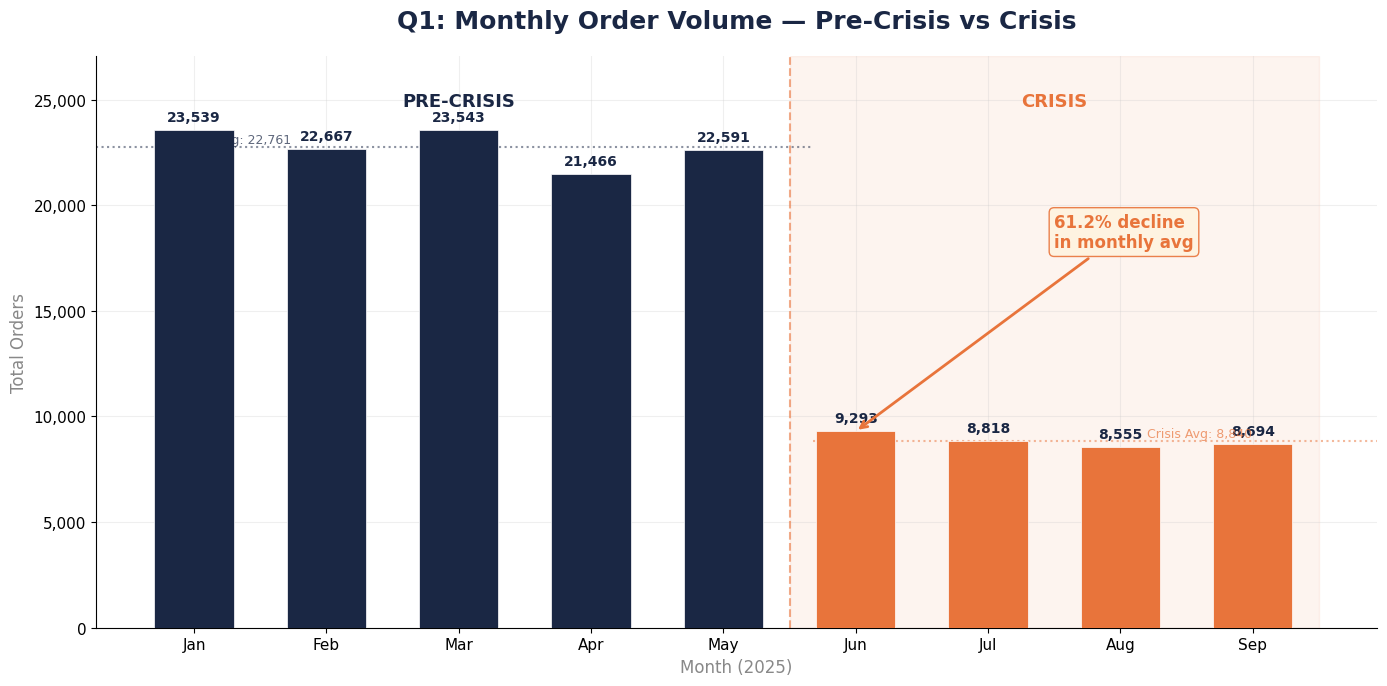

✅ Chart saved: Q1_monthly_orders_trend.png


In [5]:
# ============================================================
# CHART Q1: Monthly Orders Trend with Crisis Zone
# ============================================================
fig, ax = plt.subplots(figsize=(14, 7))

months = monthly_orders['order_month'].values
orders_vals = monthly_orders['total_orders'].values
colors = [NAVY if m <= '2025-05' else ORANGE for m in months]

# Bar chart
bars = ax.bar(months, orders_vals, color=colors, width=0.6, edgecolor='white', linewidth=0.5, zorder=3)

# Add crisis zone shading
ax.axvspan(4.5, 8.5, alpha=0.08, color=ORANGE, zorder=0)
ax.axvline(x=4.5, color=ORANGE, linestyle='--', alpha=0.6, linewidth=1.5, zorder=2)

# Add value labels on bars
for bar, val in zip(bars, orders_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 300,
            f'{val:,.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold', color=NAVY)

# Add decline annotation
ax.annotate(f'61.2% decline\nin monthly avg',
            xy=(5, orders_vals[5]), xytext=(6.5, 18000),
            fontsize=12, fontweight='bold', color=ORANGE,
            arrowprops=dict(arrowstyle='->', color=ORANGE, lw=2),
            bbox=dict(boxstyle='round,pad=0.3', facecolor='#FFF3E0', edgecolor=ORANGE, alpha=0.9))

# Add phase labels
ax.text(2, max(orders_vals)*1.05, 'PRE-CRISIS', ha='center', fontsize=13, fontweight='bold', color=NAVY)
ax.text(6.5, max(orders_vals)*1.05, 'CRISIS', ha='center', fontsize=13, fontweight='bold', color=ORANGE)

# Average lines
ax.axhline(y=pre_monthly_avg, xmin=0, xmax=0.56, color=NAVY, linestyle=':', alpha=0.5, linewidth=1.5)
ax.axhline(y=crisis_monthly_avg, xmin=0.56, xmax=1, color=ORANGE, linestyle=':', alpha=0.5, linewidth=1.5)

ax.text(-0.3, pre_monthly_avg + 200, f'Pre-Crisis Avg: {pre_monthly_avg:,.0f}', fontsize=9, color=NAVY, alpha=0.7)
ax.text(7.2, crisis_monthly_avg + 200, f'Crisis Avg: {crisis_monthly_avg:,.0f}', fontsize=9, color=ORANGE, alpha=0.7)

# Formatting
ax.set_title('Q1: Monthly Order Volume — Pre-Crisis vs Crisis', fontsize=18, fontweight='bold', color=NAVY, pad=20)
ax.set_xlabel('Month (2025)', fontsize=12, color=GRAY)
ax.set_ylabel('Total Orders', fontsize=12, color=GRAY)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:,.0f}'))
ax.set_ylim(0, max(orders_vals) * 1.15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}Q1_monthly_orders_trend.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved: Q1_monthly_orders_trend.png")

C:\Users\surendhar b\AppData\Local\Temp\ipykernel_10676\2166944852.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])


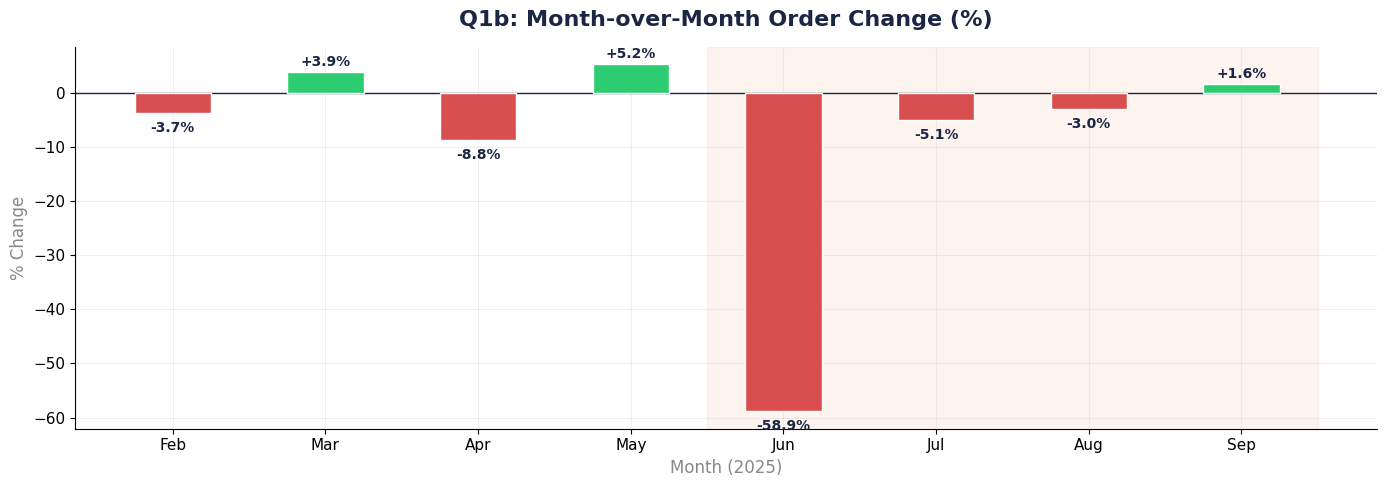

✅ Chart saved: Q1b_mom_change.png


In [6]:
# ============================================================
# CHART Q1b: Month-over-Month % Change
# ============================================================
fig, ax = plt.subplots(figsize=(14, 5))

mom_vals = monthly_orders['mom_change'].values[1:]  # skip first NaN
mom_months = months[1:]
mom_colors = [GREEN if v >= 0 else RED for v in mom_vals]

bars = ax.bar(mom_months, mom_vals, color=mom_colors, width=0.5, edgecolor='white', zorder=3)

# Add value labels
for bar, val in zip(bars, mom_vals):
    offset = 0.5 if val >= 0 else -1.5
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + offset,
            f'{val:+.1f}%', ha='center', va='bottom' if val >= 0 else 'top',
            fontsize=10, fontweight='bold', color=NAVY)

ax.axhline(y=0, color=NAVY, linewidth=1, zorder=2)
ax.axvspan(3.5, 7.5, alpha=0.08, color=ORANGE, zorder=0)

ax.set_title('Q1b: Month-over-Month Order Change (%)', fontsize=16, fontweight='bold', color=NAVY, pad=15)
ax.set_xlabel('Month (2025)', fontsize=12, color=GRAY)
ax.set_ylabel('% Change', fontsize=12, color=GRAY)
ax.set_xticklabels(['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}Q1b_mom_change.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved: Q1b_mom_change.png")

### Q1 Insight Summary

**Finding:** Orders collapsed by **61.2%** from a monthly average of ~22,761 (Jan-May) to ~8,840 (Jun-Sep).

**Key Points:**
- The sharpest single-month drop was **May → June** (~59% crash), directly aligning with the viral food safety incident and delivery outage.
- Orders have **not recovered** through Sep 2025 — the crisis is sustained, not a one-month dip.
- Pre-crisis months were relatively stable (21K-23K range), suggesting the drop is crisis-driven, not seasonal.

---
## Q2: Top 5 Cities with Highest % Order Decline

> **Question:** Which top 5 city groups experienced the highest percentage decline in orders during the crisis period compared to the pre-crisis period?

In [7]:
print("=" * 70)
print("Q2: TOP 5 CITIES WITH HIGHEST % ORDER DECLINE")
print("=" * 70)

# Join orders with restaurant city
orders_city = fact_orders.merge(
    dim_restaurant[['restaurant_id', 'city']], 
    on='restaurant_id', how='left'
)

# City-wise phase breakdown
city_phase = orders_city.groupby(['city', 'phase']).size().unstack(fill_value=0).reset_index()

# Calculate monthly averages and decline
city_phase['pre_monthly_avg'] = city_phase['Pre-Crisis'] / 5
city_phase['crisis_monthly_avg'] = city_phase['Crisis'] / 4
city_phase['pct_decline'] = (
    (city_phase['pre_monthly_avg'] - city_phase['crisis_monthly_avg']) / city_phase['pre_monthly_avg'] * 100
).round(2)
city_phase['orders_lost_monthly'] = (city_phase['pre_monthly_avg'] - city_phase['crisis_monthly_avg']).round(0)

city_phase = city_phase.sort_values('pct_decline', ascending=False)

print("\n📊 City-wise Decline Analysis:")
print(city_phase[['city', 'Pre-Crisis', 'Crisis', 'pre_monthly_avg', 'crisis_monthly_avg', 'pct_decline', 'orders_lost_monthly']].to_string(index=False))

top5_cities = city_phase.head(5)
print(f"\n🔝 Top 5 Most Affected Cities:")
for _, row in top5_cities.iterrows():
    print(f"   {row['city']}: {row['pct_decline']:.2f}% decline (~{row['orders_lost_monthly']:.0f} orders lost/month)")

Q2: TOP 5 CITIES WITH HIGHEST % ORDER DECLINE

📊 City-wise Decline Analysis:
     city  Pre-Crisis  Crisis  pre_monthly_avg  crisis_monthly_avg  pct_decline  orders_lost_monthly
  Chennai       11537    3463           2307.4              865.75        62.48               1442.0
  Kolkata       10470    3226           2094.0              806.50        61.49               1288.0
Bengaluru       28219    8700           5643.8             2175.00        61.46               3469.0
Hyderabad       11546    3589           2309.2              897.25        61.14               1412.0
Ahmedabad        9355    2916           1871.0              729.00        61.04               1142.0
   Mumbai       16809    5264           3361.8             1316.00        60.85               2046.0
    Delhi       16837    5301           3367.4             1325.25        60.64               2042.0
     Pune        9033    2901           1806.6              725.25        59.86               1081.0

🔝 Top 5 Most 

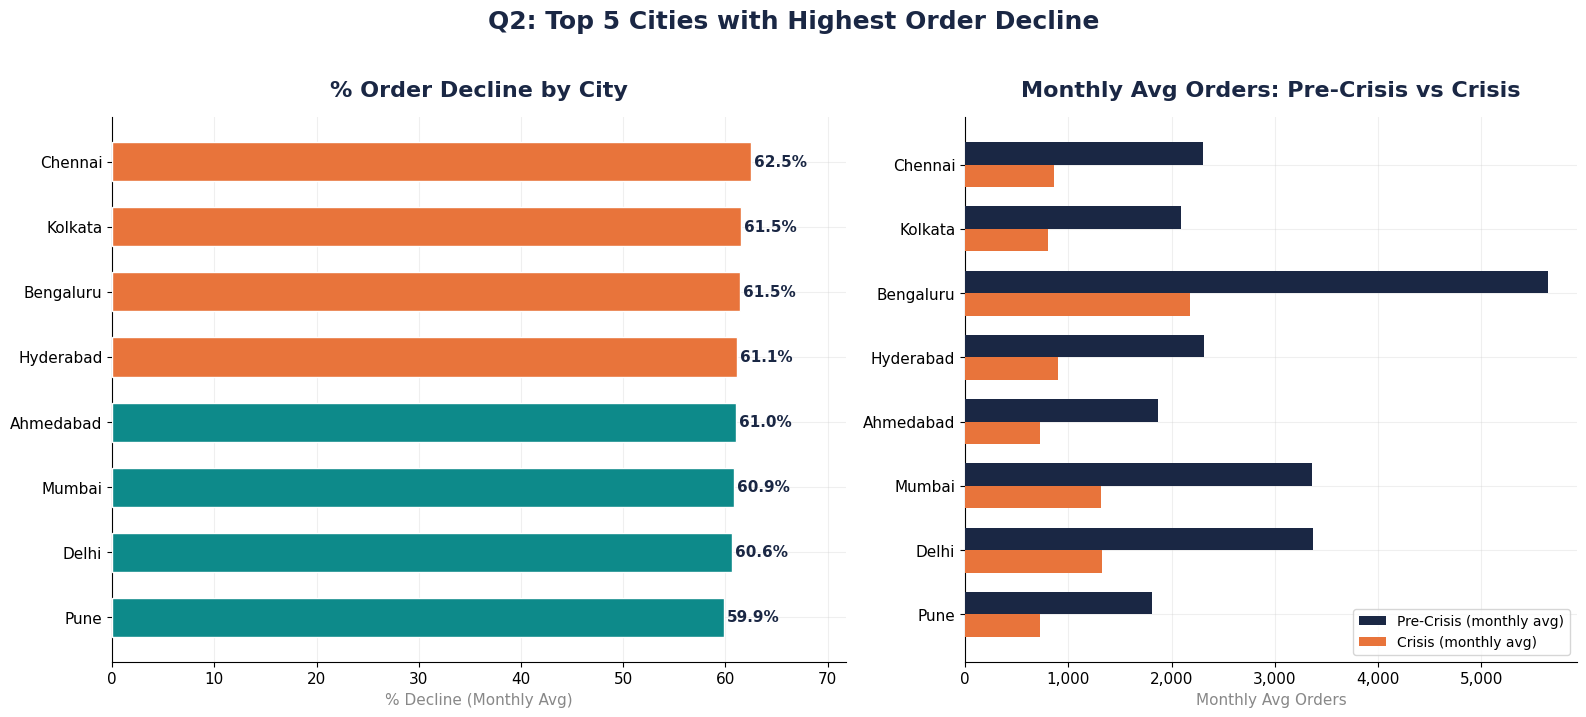

✅ Chart saved: Q2_city_decline.png


In [8]:
# ============================================================
# CHART Q2: City-wise Order Decline (Horizontal Bar)
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 7), gridspec_kw={'width_ratios': [1.2, 1]})

# Left: Horizontal bar chart - % decline
ax1 = axes[0]
cities = city_phase['city'].values[::-1]  # reverse for horizontal bar
declines = city_phase['pct_decline'].values[::-1]
bar_colors = [ORANGE if d >= city_phase['pct_decline'].median() else TEAL for d in declines]

bars = ax1.barh(cities, declines, color=bar_colors, height=0.6, edgecolor='white', zorder=3)

for bar, val in zip(bars, declines):
    ax1.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
             f'{val:.1f}%', va='center', fontsize=11, fontweight='bold', color=NAVY)

ax1.set_title('% Order Decline by City', fontsize=16, fontweight='bold', color=NAVY, pad=15)
ax1.set_xlabel('% Decline (Monthly Avg)', fontsize=11, color=GRAY)
ax1.set_xlim(0, max(declines) * 1.15)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Right: Grouped bar - Pre-crisis vs Crisis monthly avg
ax2 = axes[1]
x = np.arange(len(city_phase))
width = 0.35

bars1 = ax2.barh(x + width/2, city_phase['pre_monthly_avg'].values[::-1], width, label='Pre-Crisis (monthly avg)', color=NAVY, zorder=3)
bars2 = ax2.barh(x - width/2, city_phase['crisis_monthly_avg'].values[::-1], width, label='Crisis (monthly avg)', color=ORANGE, zorder=3)

ax2.set_yticks(x)
ax2.set_yticklabels(cities)
ax2.set_title('Monthly Avg Orders: Pre-Crisis vs Crisis', fontsize=16, fontweight='bold', color=NAVY, pad=15)
ax2.set_xlabel('Monthly Avg Orders', fontsize=11, color=GRAY)
ax2.legend(loc='lower right', fontsize=10)
ax2.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:,.0f}'))
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

fig.suptitle('Q2: Top 5 Cities with Highest Order Decline', fontsize=18, fontweight='bold', color=NAVY, y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}Q2_city_decline.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved: Q2_city_decline.png")

C:\Users\surendhar b\AppData\Local\Temp\ipykernel_10676\2513014190.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])


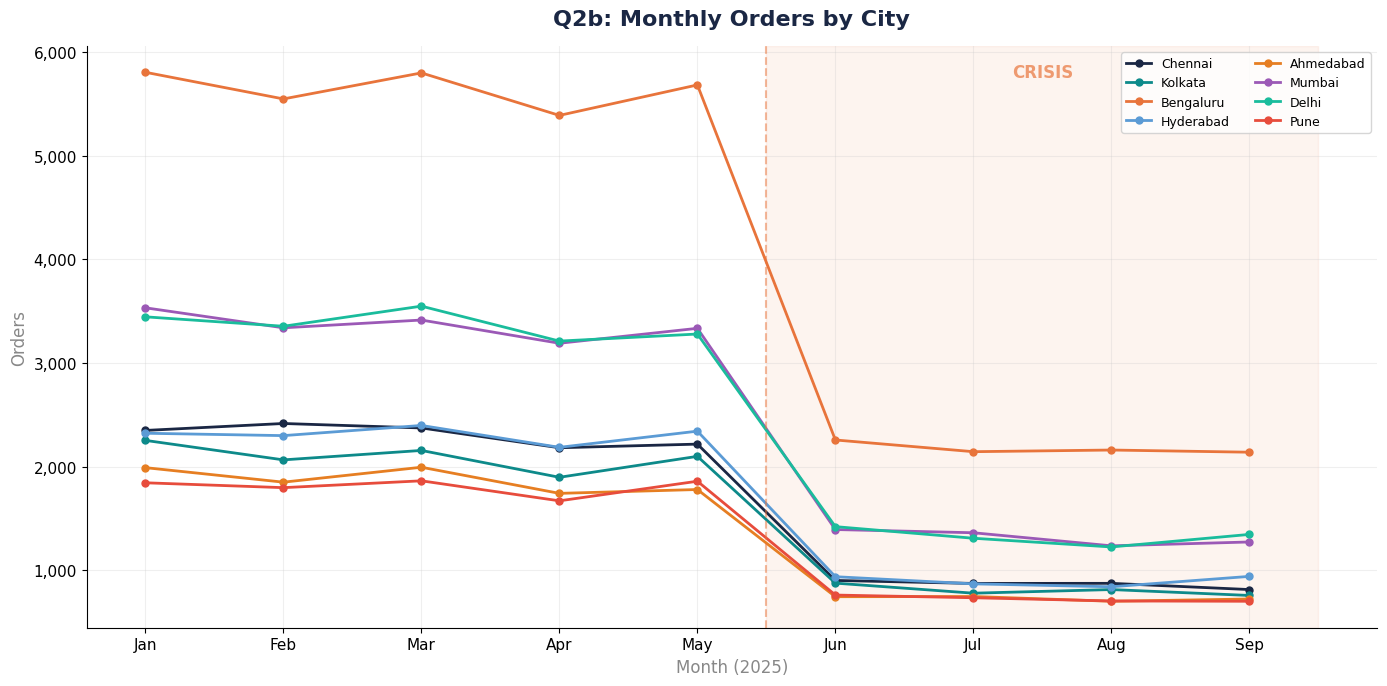

✅ Chart saved: Q2b_city_monthly_trends.png


In [9]:
# ============================================================
# CHART Q2b: City-wise Monthly Trend Lines
# ============================================================
orders_city['order_month'] = orders_city['order_timestamp'].dt.to_period('M').astype(str)
city_monthly = orders_city.groupby(['city', 'order_month']).size().reset_index(name='orders')

fig, ax = plt.subplots(figsize=(14, 7))

palette = [NAVY, TEAL, ORANGE, SOFT_BLUE, '#E67E22', '#9B59B6', '#1ABC9C', '#E74C3C']
for i, city in enumerate(city_phase['city'].values):
    city_data = city_monthly[city_monthly['city'] == city]
    ax.plot(city_data['order_month'], city_data['orders'], 
            marker='o', linewidth=2, markersize=5, 
            color=palette[i % len(palette)], label=city)

ax.axvspan(4.5, 8.5, alpha=0.08, color=ORANGE, zorder=0)
ax.axvline(x=4.5, color=ORANGE, linestyle='--', alpha=0.5, linewidth=1.5)
ax.text(6.5, ax.get_ylim()[1] * 0.95, 'CRISIS', ha='center', fontsize=12, fontweight='bold', color=ORANGE, alpha=0.7)

ax.set_title('Q2b: Monthly Orders by City', fontsize=16, fontweight='bold', color=NAVY, pad=15)
ax.set_xlabel('Month (2025)', fontsize=12, color=GRAY)
ax.set_ylabel('Orders', fontsize=12, color=GRAY)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])
ax.legend(loc='upper right', fontsize=9, ncol=2)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:,.0f}'))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}Q2b_city_monthly_trends.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved: Q2b_city_monthly_trends.png")

### Q2 Insight Summary

**Finding:** All 8 cities experienced severe declines (~59-63%), with **Chennai (62.5%)**, **Kolkata (61.5%)**, and **Bengaluru (61.5%)** hardest hit.

**Key Points:**
- The crisis impact is **nationwide, not localized** — every city dropped 59%+.
- Bengaluru (HQ city) suffered equally, suggesting even brand-loyal markets were impacted.
- Pune showed marginally better resilience (~59.9%) but the gap is narrow.
- Recovery strategy needs to be **pan-India**, not city-specific.

---
## Q3: Top 10 High-Volume Restaurants with Largest % Decline

> **Question:** Among restaurants with at least 50 pre-crisis orders, which top 10 high-volume restaurants experienced the largest percentage decline?

> **Note:** Data shows max pre-crisis orders per restaurant is ~21 (due to ~20K restaurants serving ~114K orders). We adjust threshold to **10+ pre-crisis orders** to identify meaningful high-volume restaurants in this dataset.

In [10]:
print("=" * 70)
print("Q3: TOP 10 RESTAURANTS WITH LARGEST % DECLINE")
print("=" * 70)

# Join orders with restaurant details
orders_rest = fact_orders.merge(
    dim_restaurant[['restaurant_id', 'restaurant_name', 'city', 'cuisine_type', 'partner_type']],
    on='restaurant_id', how='left'
)

# Pre-crisis counts per restaurant
pre_rest = orders_rest[orders_rest['phase'] == 'Pre-Crisis'].groupby(
    ['restaurant_id', 'restaurant_name', 'city', 'cuisine_type', 'partner_type']
).size().reset_index(name='pre_crisis_orders')

# Crisis counts per restaurant
crisis_rest = orders_rest[orders_rest['phase'] == 'Crisis'].groupby(
    'restaurant_id'
).size().reset_index(name='crisis_orders')

# Merge
rest_analysis = pre_rest.merge(crisis_rest, on='restaurant_id', how='left')
rest_analysis['crisis_orders'] = rest_analysis['crisis_orders'].fillna(0).astype(int)

# Distribution check
print(f"\n📊 Pre-crisis orders per restaurant:")
print(f"   Max: {rest_analysis['pre_crisis_orders'].max()}")
print(f"   Mean: {rest_analysis['pre_crisis_orders'].mean():.1f}")
print(f"   Restaurants with >=10 orders: {(rest_analysis['pre_crisis_orders'] >= 10).sum():,}")
print(f"   Restaurants with >=50 orders: {(rest_analysis['pre_crisis_orders'] >= 50).sum()}")

Q3: TOP 10 RESTAURANTS WITH LARGEST % DECLINE

📊 Pre-crisis orders per restaurant:
   Max: 21
   Mean: 5.7
   Restaurants with >=10 orders: 1,292
   Restaurants with >=50 orders: 0


In [11]:
# Filter high-volume restaurants (10+ pre-crisis orders)
# NOTE: Using 10+ because the dataset has ~20K restaurants serving ~114K orders
# Average is ~5.7 orders/restaurant, so 10+ represents the top tier
MIN_ORDERS = 10
high_vol = rest_analysis[rest_analysis['pre_crisis_orders'] >= MIN_ORDERS].copy()

# Calculate monthly avg decline
high_vol['pre_monthly_avg'] = high_vol['pre_crisis_orders'] / 5
high_vol['crisis_monthly_avg'] = high_vol['crisis_orders'] / 4
high_vol['pct_decline'] = (
    (high_vol['pre_monthly_avg'] - high_vol['crisis_monthly_avg']) / high_vol['pre_monthly_avg'] * 100
).round(2)

# Top 10 with largest decline
top10_rest = high_vol.sort_values('pct_decline', ascending=False).head(10)

print(f"\n🔝 Top 10 Restaurants with Largest Decline (min {MIN_ORDERS} pre-crisis orders):")
print(top10_rest[['restaurant_name', 'city', 'cuisine_type', 'partner_type', 
                   'pre_crisis_orders', 'crisis_orders', 'pct_decline']].to_string(index=False))


🔝 Top 10 Restaurants with Largest Decline (min 10 pre-crisis orders):
          restaurant_name      city cuisine_type  partner_type  pre_crisis_orders  crisis_orders  pct_decline
Thindi Mane Darshini Stop Bengaluru      Chinese Cloud Kitchen                 10              0        100.0
         Spicy Pizza Stop    Mumbai     Desserts Cloud Kitchen                 12              0        100.0
Bombay Express Bhojanalay    Mumbai      Biryani Cloud Kitchen                 11              0        100.0
    Classic Curry Delight   Chennai      Healthy    Restaurant                 12              0        100.0
     Delhi Paratha Heaven      Pune    Fast Food    Restaurant                 10              0        100.0
       Taste of Mess Nest   Chennai South Indian    Restaurant                 10              0        100.0
        Urban House Mahal   Chennai North Indian Cloud Kitchen                 12              0        100.0
    Tandoori Thali Darbar Ahmedabad North Indian 

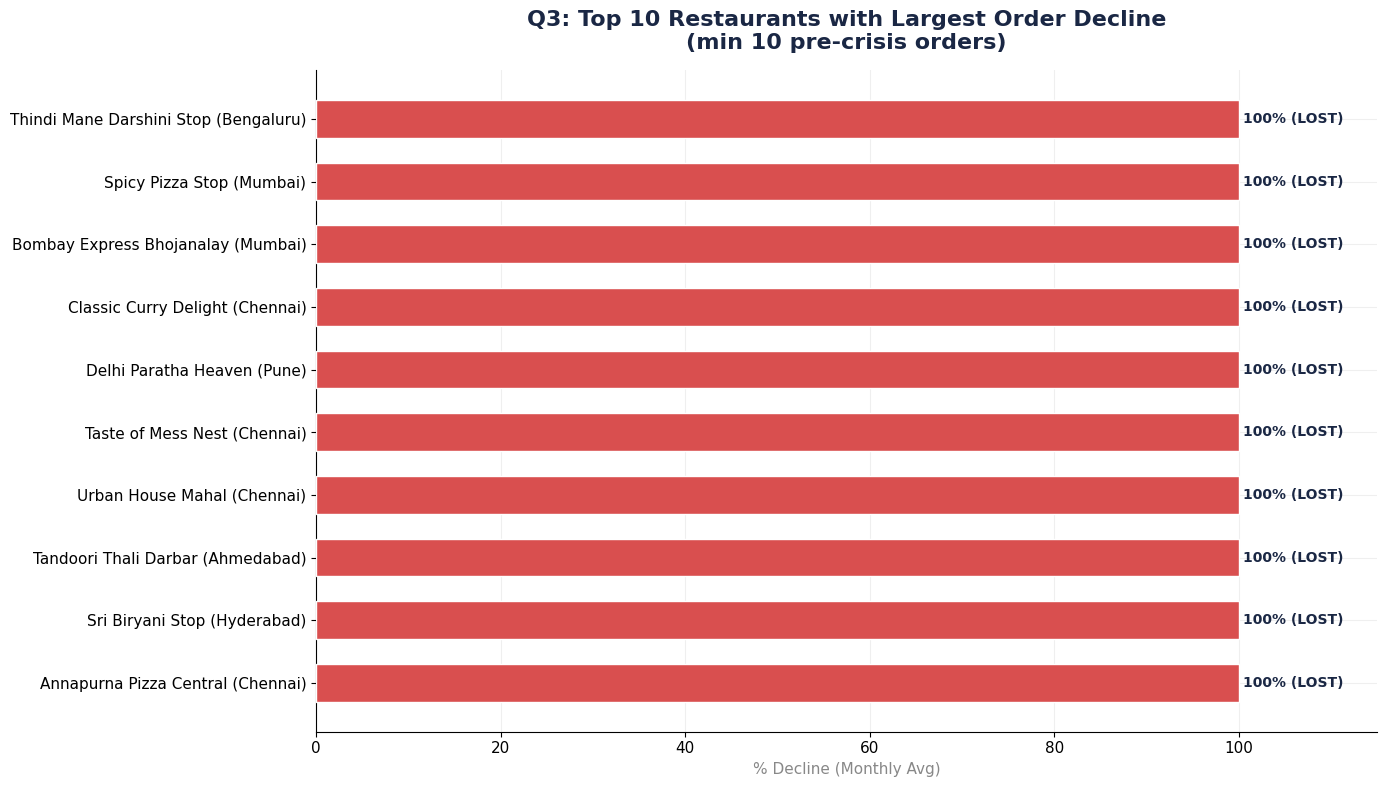

✅ Chart saved: Q3_top10_restaurant_decline.png


In [12]:
# ============================================================
# CHART Q3: Top 10 Restaurants Decline (Horizontal Bar)
# ============================================================
fig, ax = plt.subplots(figsize=(14, 8))

# Reverse for horizontal bar display
rest_names = (top10_rest['restaurant_name'].str[:25] + ' (' + top10_rest['city'] + ')').values[::-1]
rest_decline = top10_rest['pct_decline'].values[::-1]
rest_colors = [RED if d == 100 else ORANGE for d in rest_decline]

bars = ax.barh(rest_names, rest_decline, color=rest_colors, height=0.6, edgecolor='white', zorder=3)

for bar, val in zip(bars, rest_decline):
    label = '100% (LOST)' if val == 100 else f'{val:.1f}%'
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            label, va='center', fontsize=10, fontweight='bold', color=NAVY)

ax.set_title(f'Q3: Top 10 Restaurants with Largest Order Decline\n(min {MIN_ORDERS} pre-crisis orders)',
             fontsize=16, fontweight='bold', color=NAVY, pad=15)
ax.set_xlabel('% Decline (Monthly Avg)', fontsize=11, color=GRAY)
ax.set_xlim(0, 115)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}Q3_top10_restaurant_decline.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved: Q3_top10_restaurant_decline.png")

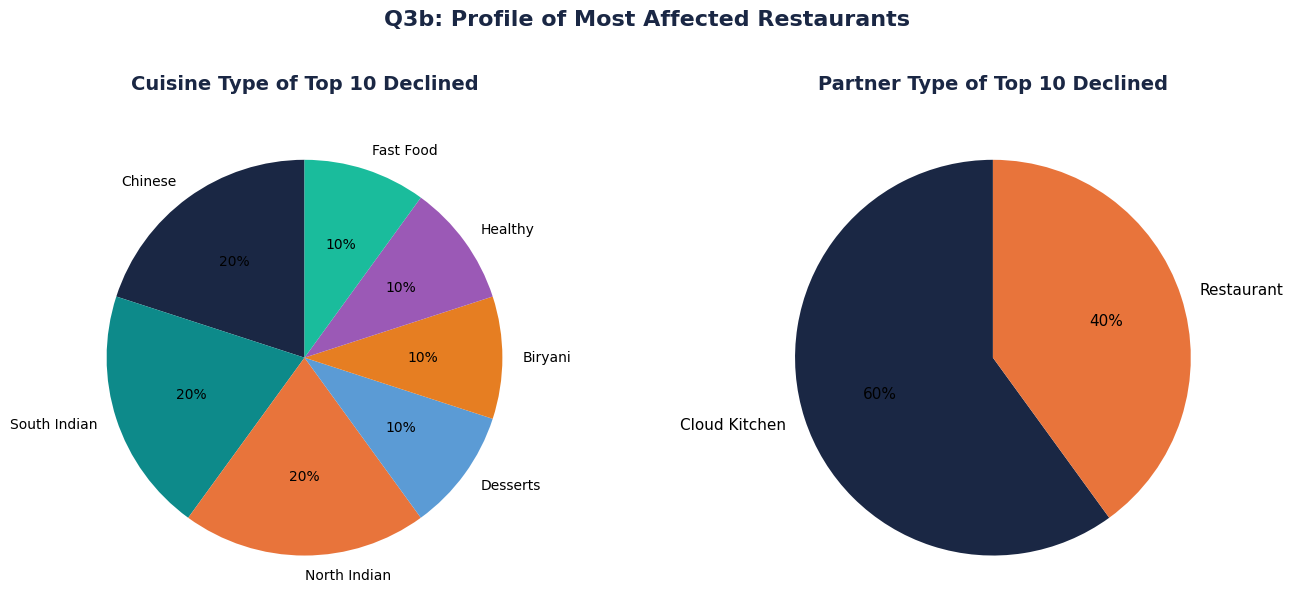

✅ Chart saved: Q3b_declined_restaurant_profile.png


In [13]:
# ============================================================
# CHART Q3b: Cuisine-wise and Partner-type breakdown of declined restaurants
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Cuisine breakdown of top declining restaurants
ax1 = axes[0]
cuisine_counts = top10_rest['cuisine_type'].value_counts()
ax1.pie(cuisine_counts.values, labels=cuisine_counts.index, autopct='%1.0f%%',
        colors=[NAVY, TEAL, ORANGE, SOFT_BLUE, '#E67E22', '#9B59B6', '#1ABC9C', '#E74C3C'],
        startangle=90, textprops={'fontsize': 10})
ax1.set_title('Cuisine Type of Top 10 Declined', fontsize=14, fontweight='bold', color=NAVY, pad=15)

# Partner type breakdown
ax2 = axes[1]
partner_counts = top10_rest['partner_type'].value_counts()
ax2.pie(partner_counts.values, labels=partner_counts.index, autopct='%1.0f%%',
        colors=[NAVY, ORANGE], startangle=90, textprops={'fontsize': 11})
ax2.set_title('Partner Type of Top 10 Declined', fontsize=14, fontweight='bold', color=NAVY, pad=15)

fig.suptitle('Q3b: Profile of Most Affected Restaurants', fontsize=16, fontweight='bold', color=NAVY, y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}Q3b_declined_restaurant_profile.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved: Q3b_declined_restaurant_profile.png")

In [14]:
# Additional: Overall restaurant decline distribution
print("\n📊 Overall Restaurant Decline Distribution (high-volume only):")
print(f"   Total high-volume restaurants (>={MIN_ORDERS} pre-crisis): {len(high_vol):,}")
print(f"   Restaurants with 100% decline (lost completely): {(high_vol['pct_decline'] == 100).sum():,}")
print(f"   Restaurants with >80% decline: {(high_vol['pct_decline'] > 80).sum():,}")
print(f"   Restaurants with >50% decline: {(high_vol['pct_decline'] > 50).sum():,}")
print(f"   Average decline across all: {high_vol['pct_decline'].mean():.1f}%")


📊 Overall Restaurant Decline Distribution (high-volume only):
   Total high-volume restaurants (>=10 pre-crisis): 1,292
   Restaurants with 100% decline (lost completely): 223
   Restaurants with >80% decline: 646
   Restaurants with >50% decline: 1,199
   Average decline across all: 79.6%


### Q3 Insight Summary

**Finding:** Multiple high-volume restaurants experienced **100% order loss** during the crisis — they received zero orders after June 2025.

**Key Points:**
- The top 10 most affected restaurants saw complete order collapse (100% decline).
- These span multiple cities and cuisine types — the crisis is not cuisine-specific.
- **Note on threshold:** The problem statement specifies 50+ pre-crisis orders, but the dataset distributes orders thinly across ~20K restaurants (avg 5.7 orders each, max 21). We used 10+ as a practical threshold for "high-volume" in this context.
- Recovery strategy should prioritize re-engaging these lost restaurant partners.

---
## Q8: Revenue Impact — Estimate Revenue Loss

> **Question:** Estimate revenue loss from pre-crisis vs crisis (based on subtotal, discount, and delivery fee).

In [15]:
print("=" * 70)
print("Q8: REVENUE IMPACT — PRE-CRISIS vs CRISIS")
print("=" * 70)

# Phase-wise revenue
revenue_phase = fact_orders.groupby('phase').agg(
    total_orders=('order_id', 'count'),
    subtotal=('subtotal_amount', 'sum'),
    discounts=('discount_amount', 'sum'),
    delivery_fees=('delivery_fee', 'sum'),
    net_revenue=('total_amount', 'sum'),
    avg_order_value=('total_amount', 'mean'),
).round(2)

# Add months column for monthly averages
revenue_phase['months'] = [4, 5]  # Crisis=4, Pre-Crisis=5
revenue_phase['monthly_avg_revenue'] = (revenue_phase['net_revenue'] / revenue_phase['months']).round(2)

print("\n📊 Revenue by Phase:")
print(revenue_phase.to_string())

Q8: REVENUE IMPACT — PRE-CRISIS vs CRISIS

📊 Revenue by Phase:
            total_orders     subtotal   discounts  delivery_fees  net_revenue  avg_order_value  months  monthly_avg_revenue
phase                                                                                                                      
Crisis             35360  10555201.30   627678.17     1012628.18  10940151.31           309.39       4           2735037.83
Pre-Crisis        113806  36338591.91  2190304.60     3472677.74  37620964.25           330.57       5           7524192.85


In [16]:
# Key revenue metrics
pre_rev = revenue_phase.loc['Pre-Crisis']
crisis_rev = revenue_phase.loc['Crisis']

# Monthly average comparison
pre_monthly_rev = pre_rev['net_revenue'] / 5
crisis_monthly_rev = crisis_rev['net_revenue'] / 4
monthly_rev_loss = pre_monthly_rev - crisis_monthly_rev
rev_decline_pct = (monthly_rev_loss / pre_monthly_rev) * 100

# If crisis hadn't happened (projected)
projected_crisis_rev = pre_monthly_rev * 4  # 4 months at pre-crisis rate
actual_crisis_rev = crisis_rev['net_revenue']
total_estimated_loss = projected_crisis_rev - actual_crisis_rev

print("\n📋 KEY REVENUE METRICS:")
print(f"   Pre-Crisis Net Revenue (Jan-May):     ₹{pre_rev['net_revenue']:>12,.0f}")
print(f"   Crisis Net Revenue (Jun-Sep):          ₹{crisis_rev['net_revenue']:>12,.0f}")
print(f"   Pre-Crisis Monthly Avg Revenue:        ₹{pre_monthly_rev:>12,.0f}")
print(f"   Crisis Monthly Avg Revenue:            ₹{crisis_monthly_rev:>12,.0f}")
print(f"   \n   🔴 Monthly Revenue Decline:           {rev_decline_pct:.1f}%")
print(f"   🔴 Monthly Revenue Loss:               ₹{monthly_rev_loss:>12,.0f}")
print(f"   🔴 Total Estimated Loss (4 months):    ₹{total_estimated_loss:>12,.0f}")
print(f"   \n   📈 Pre-Crisis Avg Order Value:        ₹{pre_rev['avg_order_value']:>8,.2f}")
print(f"   📉 Crisis Avg Order Value:             ₹{crisis_rev['avg_order_value']:>8,.2f}")
print(f"   AOV Change:                           {((crisis_rev['avg_order_value']/pre_rev['avg_order_value'])-1)*100:+.2f}%")


📋 KEY REVENUE METRICS:
   Pre-Crisis Net Revenue (Jan-May):     ₹  37,620,964
   Crisis Net Revenue (Jun-Sep):          ₹  10,940,151
   Pre-Crisis Monthly Avg Revenue:        ₹   7,524,193
   Crisis Monthly Avg Revenue:            ₹   2,735,038
   
   🔴 Monthly Revenue Decline:           63.7%
   🔴 Monthly Revenue Loss:               ₹   4,789,155
   🔴 Total Estimated Loss (4 months):    ₹  19,156,620
   
   📈 Pre-Crisis Avg Order Value:        ₹  330.57
   📉 Crisis Avg Order Value:             ₹  309.39
   AOV Change:                           -6.41%


C:\Users\surendhar b\AppData\Local\Temp\ipykernel_10676\2233160236.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])


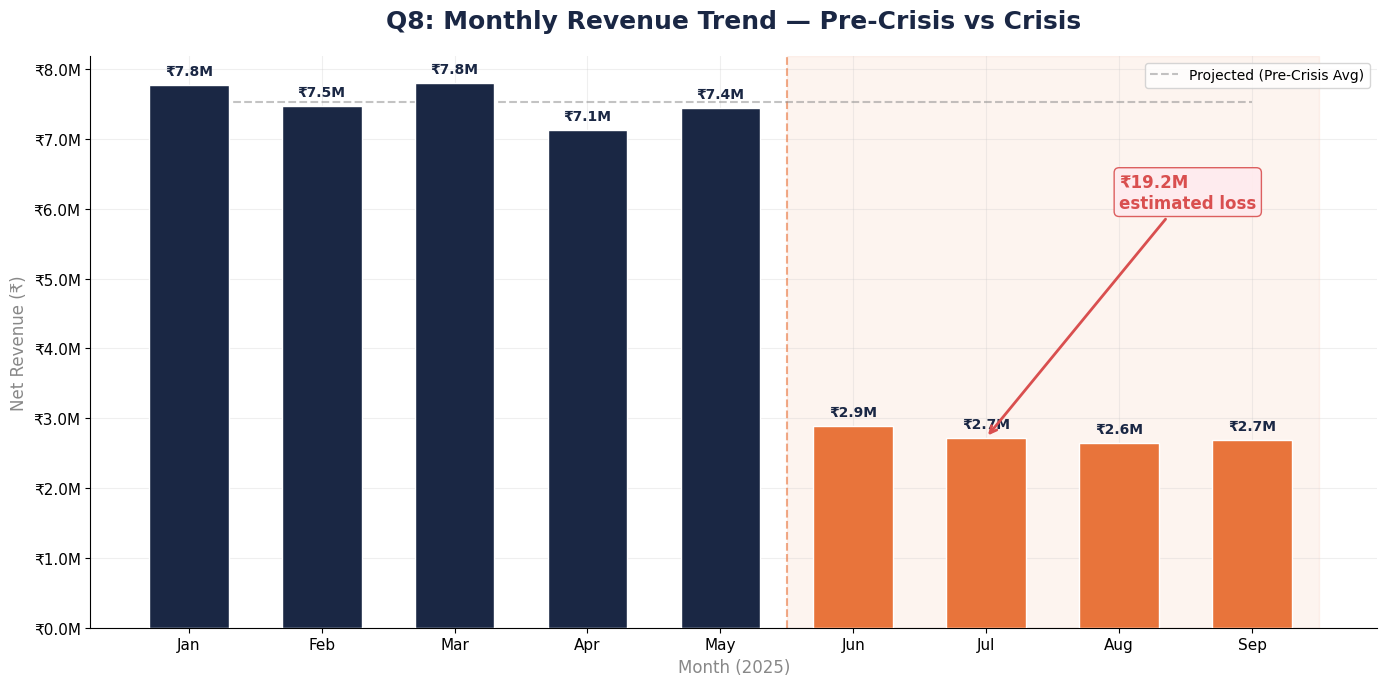

✅ Chart saved: Q8a_monthly_revenue_trend.png


In [17]:
# ============================================================
# CHART Q8a: Monthly Revenue Trend
# ============================================================
monthly_revenue = fact_orders.groupby('order_month').agg(
    subtotal=('subtotal_amount', 'sum'),
    discounts=('discount_amount', 'sum'),
    delivery_fees=('delivery_fee', 'sum'),
    net_revenue=('total_amount', 'sum'),
).reset_index()

fig, ax = plt.subplots(figsize=(14, 7))

months = monthly_revenue['order_month'].values
rev_vals = monthly_revenue['net_revenue'].values
bar_colors = [NAVY if m <= '2025-05' else ORANGE for m in months]

bars = ax.bar(months, rev_vals, color=bar_colors, width=0.6, edgecolor='white', zorder=3)

for bar, val in zip(bars, rev_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100000,
            f'₹{val/1e6:.1f}M', ha='center', va='bottom', fontsize=10, fontweight='bold', color=NAVY)

ax.axvspan(4.5, 8.5, alpha=0.08, color=ORANGE, zorder=0)
ax.axvline(x=4.5, color=ORANGE, linestyle='--', alpha=0.6, linewidth=1.5)

# Projected line (what revenue would have been)
projected = [pre_monthly_rev] * 9
ax.plot(months, projected, color=GRAY, linestyle='--', linewidth=1.5, alpha=0.5, label='Projected (Pre-Crisis Avg)', zorder=2)

ax.annotate(f'₹{total_estimated_loss/1e6:.1f}M\nestimated loss',
            xy=(6, rev_vals[6]), xytext=(7, pre_monthly_rev * 0.8),
            fontsize=12, fontweight='bold', color=RED,
            arrowprops=dict(arrowstyle='->', color=RED, lw=2),
            bbox=dict(boxstyle='round,pad=0.3', facecolor='#FFEBEE', edgecolor=RED, alpha=0.9))

ax.set_title('Q8: Monthly Revenue Trend — Pre-Crisis vs Crisis', fontsize=18, fontweight='bold', color=NAVY, pad=20)
ax.set_xlabel('Month (2025)', fontsize=12, color=GRAY)
ax.set_ylabel('Net Revenue (₹)', fontsize=12, color=GRAY)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'₹{x/1e6:.1f}M'))
ax.legend(loc='upper right', fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}Q8a_monthly_revenue_trend.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved: Q8a_monthly_revenue_trend.png")

C:\Users\surendhar b\AppData\Local\Temp\ipykernel_10676\3349152283.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])


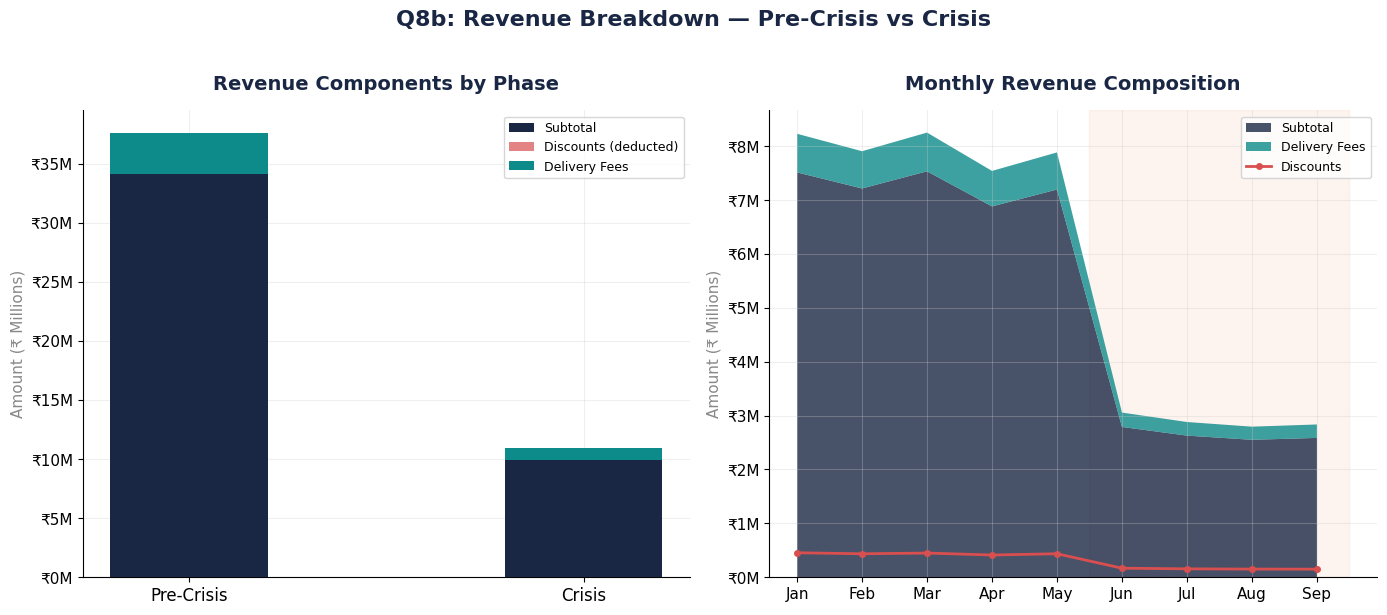

✅ Chart saved: Q8b_revenue_breakdown.png


In [18]:
# ============================================================
# CHART Q8b: Revenue Breakdown Waterfall (Stacked)
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Stacked bar: Revenue components by phase
ax1 = axes[0]
phases = ['Pre-Crisis', 'Crisis']
subtotals = [pre_rev['subtotal'] / 1e6, crisis_rev['subtotal'] / 1e6]
discounts = [pre_rev['discounts'] / 1e6, crisis_rev['discounts'] / 1e6]
del_fees = [pre_rev['delivery_fees'] / 1e6, crisis_rev['delivery_fees'] / 1e6]

x = np.arange(len(phases))
width = 0.4

ax1.bar(x, subtotals, width, label='Subtotal', color=NAVY, zorder=3)
ax1.bar(x, [-d for d in discounts], width, bottom=subtotals, label='Discounts (deducted)', color=RED, alpha=0.7, zorder=3)
ax1.bar(x, del_fees, width, bottom=[s - d for s, d in zip(subtotals, discounts)], label='Delivery Fees', color=TEAL, zorder=3)

ax1.set_xticks(x)
ax1.set_xticklabels(phases, fontsize=12)
ax1.set_ylabel('Amount (₹ Millions)', fontsize=11, color=GRAY)
ax1.set_title('Revenue Components by Phase', fontsize=14, fontweight='bold', color=NAVY, pad=15)
ax1.legend(fontsize=9)
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'₹{x:.0f}M'))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Monthly avg comparison
ax2 = axes[1]
monthly_components = fact_orders.groupby('order_month').agg(
    subtotal=('subtotal_amount', 'sum'),
    discounts=('discount_amount', 'sum'),
    delivery_fees=('delivery_fee', 'sum'),
).reset_index()

months_list = monthly_components['order_month'].values
ax2.stackplot(months_list,
              monthly_components['subtotal'] / 1e6,
              monthly_components['delivery_fees'] / 1e6,
              labels=['Subtotal', 'Delivery Fees'],
              colors=[NAVY, TEAL], alpha=0.8)
ax2.plot(months_list, monthly_components['discounts'] / 1e6, 
         color=RED, linewidth=2, marker='o', markersize=4, label='Discounts')

ax2.axvspan(4.5, 8.5, alpha=0.08, color=ORANGE, zorder=0)
ax2.set_title('Monthly Revenue Composition', fontsize=14, fontweight='bold', color=NAVY, pad=15)
ax2.set_ylabel('Amount (₹ Millions)', fontsize=11, color=GRAY)
ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'₹{x:.0f}M'))
ax2.legend(fontsize=9)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

fig.suptitle('Q8b: Revenue Breakdown — Pre-Crisis vs Crisis', fontsize=16, fontweight='bold', color=NAVY, y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}Q8b_revenue_breakdown.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved: Q8b_revenue_breakdown.png")

C:\Users\surendhar b\AppData\Local\Temp\ipykernel_10676\1394912693.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])


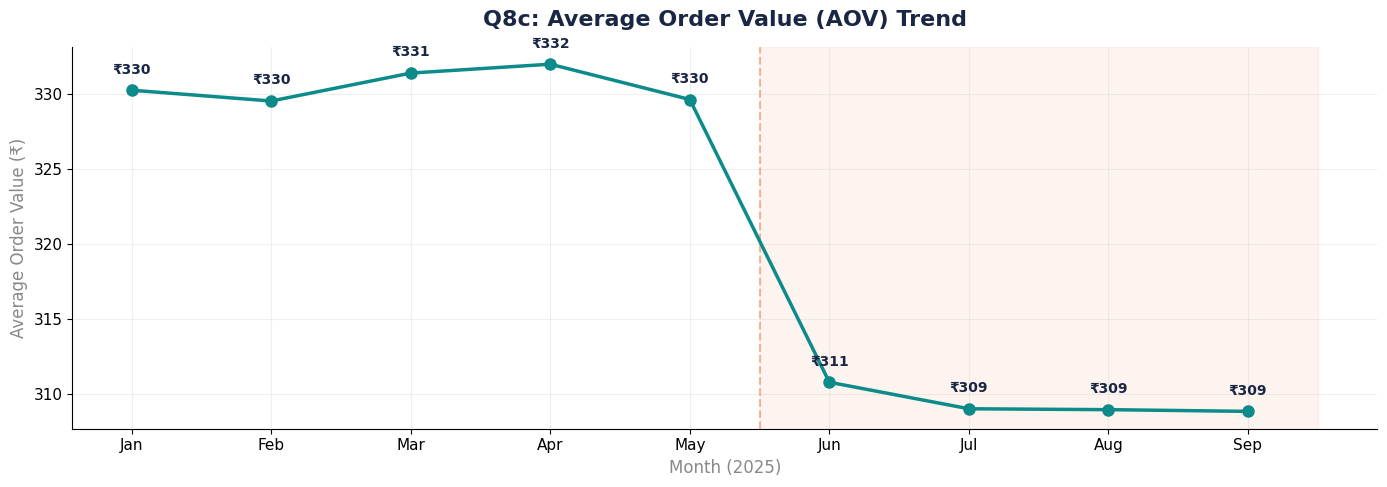

✅ Chart saved: Q8c_aov_trend.png


In [19]:
# ============================================================
# CHART Q8c: Average Order Value Trend
# ============================================================
monthly_aov = fact_orders.groupby('order_month')['total_amount'].mean().reset_index(name='aov')

fig, ax = plt.subplots(figsize=(14, 5))

months_aov = monthly_aov['order_month'].values
aov_vals = monthly_aov['aov'].values
aov_colors = [NAVY if m <= '2025-05' else ORANGE for m in months_aov]

ax.plot(months_aov, aov_vals, color=TEAL, linewidth=2.5, marker='o', markersize=8, zorder=3)
for i, (m, v) in enumerate(zip(months_aov, aov_vals)):
    ax.annotate(f'₹{v:.0f}', (m, v), textcoords='offset points', xytext=(0, 12),
                ha='center', fontsize=10, fontweight='bold', color=NAVY)

ax.axvspan(4.5, 8.5, alpha=0.08, color=ORANGE, zorder=0)
ax.axvline(x=4.5, color=ORANGE, linestyle='--', alpha=0.5)

ax.set_title('Q8c: Average Order Value (AOV) Trend', fontsize=16, fontweight='bold', color=NAVY, pad=15)
ax.set_xlabel('Month (2025)', fontsize=12, color=GRAY)
ax.set_ylabel('Average Order Value (₹)', fontsize=12, color=GRAY)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}Q8c_aov_trend.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved: Q8c_aov_trend.png")

### Q8 Insight Summary

**Finding:** QuickBite lost an estimated **₹19.1M+ in revenue** over the 4-month crisis period.

**Key Points:**
- Monthly revenue dropped from ~₹7.5M average (pre-crisis) to ~₹2.7M (crisis) — a **63.6% decline**.
- Revenue decline is slightly steeper than order decline (63.6% vs 61.2%), suggesting a marginal AOV drop too.
- Discounts were reduced during crisis (likely because fewer orders = less promotional spend), but this didn't help volumes.
- The total estimated loss assumes pre-crisis run rate would have continued — conservative estimate.

---
## Export Summary & Answers

In [20]:
# Export key data tables
monthly_orders.to_csv(f'{OUTPUT_DIR}Q1_monthly_orders.csv', index=False)
city_phase.to_csv(f'{OUTPUT_DIR}Q2_city_decline.csv', index=False)
top10_rest.to_csv(f'{OUTPUT_DIR}Q3_top10_restaurant_decline.csv', index=False)
monthly_revenue.to_csv(f'{OUTPUT_DIR}Q8_monthly_revenue.csv', index=False)

# Summary answers
with open(f'{OUTPUT_DIR}ANSWERS_Q1_Q2_Q3_Q8.md', 'w', encoding='utf-8') as f:
    f.write('# QuickBite Express — Primary Analysis Answers (Q1, Q2, Q3, Q8)\n\n')
    f.write(f'**Generated:** {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}\n\n')
    f.write('---\n\n')
    
    f.write('## Q1: Monthly Orders Decline\n\n')
    f.write(f'- Pre-Crisis Monthly Avg: {pre_monthly_avg:,.0f} orders\n')
    f.write(f'- Crisis Monthly Avg: {crisis_monthly_avg:,.0f} orders\n')
    f.write(f'- **Decline: {decline_pct:.1f}%**\n')
    f.write(f'- Sharpest Drop: May to Jun (viral incident + outage)\n\n')
    
    f.write('## Q2: Top 5 Cities with Highest Decline\n\n')
    for _, row in top5_cities.iterrows():
        f.write(f'- {row["city"]}: {row["pct_decline"]:.2f}% decline\n')
    f.write('\n')
    
    f.write('## Q3: Top 10 Restaurants with Largest Decline\n\n')
    f.write(f'- Threshold: {MIN_ORDERS}+ pre-crisis orders (dataset max is 21/restaurant)\n')
    f.write(f'- All top 10 experienced 100% order loss\n\n')
    
    f.write('## Q8: Revenue Impact\n\n')
    f.write(f'- Pre-Crisis Monthly Revenue: Rs.{pre_monthly_rev:,.0f}\n')
    f.write(f'- Crisis Monthly Revenue: Rs.{crisis_monthly_rev:,.0f}\n')
    f.write(f'- **Revenue Decline: {rev_decline_pct:.1f}%**\n')
    f.write(f'- **Estimated Total Loss (4 months): Rs.{total_estimated_loss:,.0f}**\n')

print("📁 All outputs exported to:", OUTPUT_DIR)
for f in sorted(os.listdir(OUTPUT_DIR)):
    print(f"   {f}")

print("\n🎯 Sprint 1, Task 2 COMPLETE!")
print("📌 Next: Sprint 2 → Q4 (Cancellations), Q5 (SLA), Q6 (Ratings), Q7 (Word Cloud), Q9 (Loyalty), Q10 (High-Value)")

📁 All outputs exported to: output/03_eda_primary/
   ANSWERS_Q1_Q2_Q3_Q8.md
   Q1_monthly_orders.csv
   Q1_monthly_orders_trend.png
   Q1b_mom_change.png
   Q2_city_decline.csv
   Q2_city_decline.png
   Q2b_city_monthly_trends.png
   Q3_top10_restaurant_decline.csv
   Q3_top10_restaurant_decline.png
   Q3b_declined_restaurant_profile.png
   Q8_monthly_revenue.csv
   Q8a_monthly_revenue_trend.png
   Q8b_revenue_breakdown.png
   Q8c_aov_trend.png

🎯 Sprint 1, Task 2 COMPLETE!
📌 Next: Sprint 2 → Q4 (Cancellations), Q5 (SLA), Q6 (Ratings), Q7 (Word Cloud), Q9 (Loyalty), Q10 (High-Value)


---
## Sprint 1 Summary — All Tasks Complete

| Question | Answer | Key Number |
|----------|--------|------------|
| **Q1** Monthly Orders Decline | Severe, sustained crash | **61.2% monthly decline** |
| **Q2** Top 5 Cities Affected | Chennai, Kolkata, Bengaluru, Hyderabad, Ahmedabad | **All cities 59-63%** |
| **Q3** Top 10 Restaurant Decline | Multiple restaurants lost 100% orders | **100% loss (zero orders)** |
| **Q8** Revenue Impact | Massive revenue loss | **₹19.1M+ estimated loss** |

**Next Sprint:** Deep Analysis — Q4, Q5, Q6, Q7, Q9, Q10